<a href="https://colab.research.google.com/github/gorzanskik-ai/computer-vision/blob/main/02_document_scanner/02_document_scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/opencv/02_document_scanner/images/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
from google.colab.patches import cv2_imshow
from skimage.filters import threshold_local
import numpy as np
from numpy.linalg import norm
import imutils
import cv2

Load image

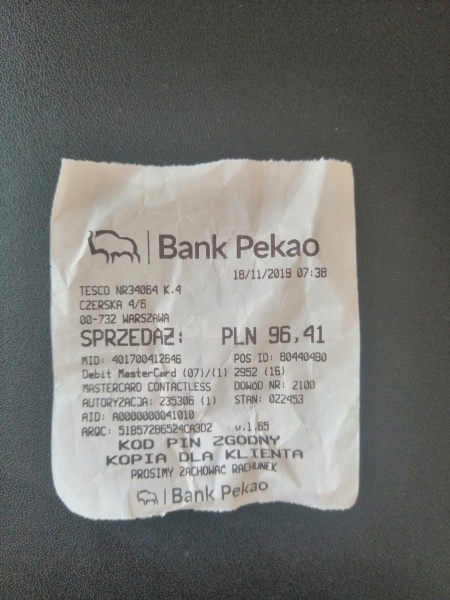

In [152]:
og_img = cv2.imread(path + 'paragon_1.jpg')
img = og_img.copy()
cv2_imshow(img)

In [153]:
ratio = img.shape[0] / 500.0
img = imutils.resize(img, height=500)
img.shape

(500, 375, 3)

Gray scale

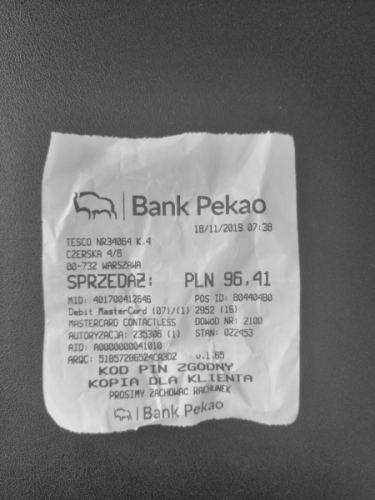

In [154]:
gray = cv2.cvtColor(img, code=cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

Blur

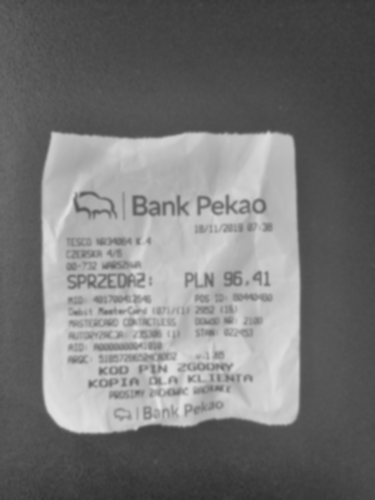

In [155]:
gray_blur = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
cv2_imshow(gray_blur)

Edge detection

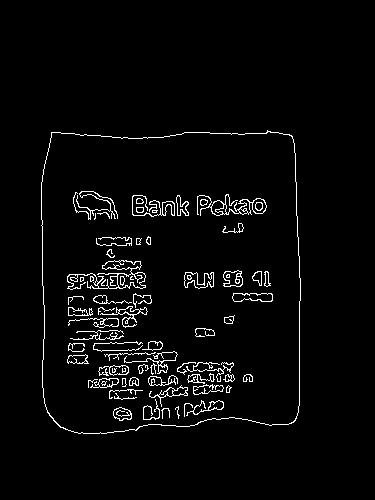

In [156]:
edges = cv2.Canny(gray_blur, threshold1=70, threshold2=200)
cv2_imshow(edges)

Find contours

In [157]:
contours = cv2.findContours(image=edges.copy(), mode=cv2.RETR_LIST, method = cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
print(f'Number of all contours: {len(contours)}')
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5] #sort by contour area

print('Number of vertex in each contour:')
for i in contours:
    print(len(i))

Number of all contours: 140
Number of vertex in each contour:
217
215
297
189
83


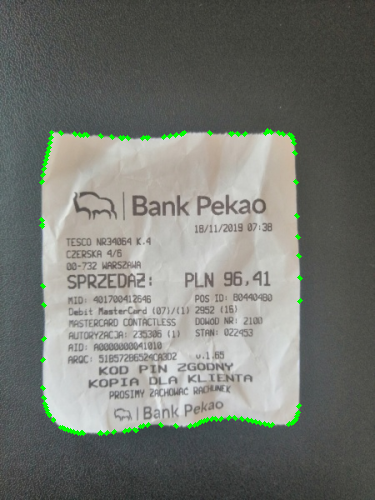

In [158]:
cnt1 = cv2.drawContours(image=img.copy(), contours=contours[0], contourIdx=-1,
                        color=(0, 255, 0), thickness=3)
cv2_imshow(cnt1)

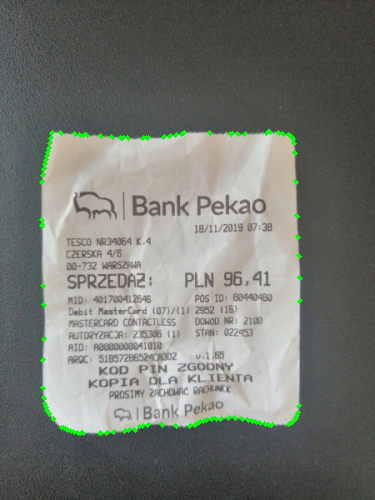

In [159]:
cnt2 = cv2.drawContours(image=img.copy(), contours=contours[1], contourIdx=-1,
                        color=(0, 255, 0), thickness=3)
cv2_imshow(cnt2)

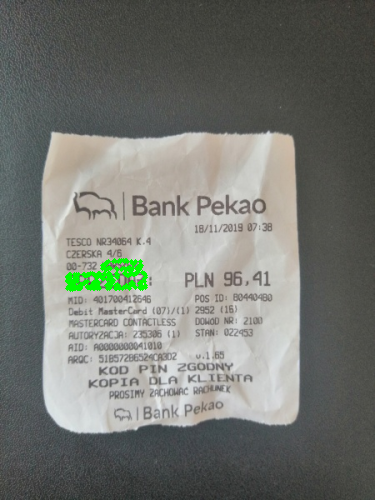

In [160]:
cnt3 = cv2.drawContours(image=img.copy(), contours=contours[2], contourIdx=-1,
                        color=(0, 255, 0), thickness=3)
cv2_imshow(cnt3)

In [161]:
for contour in contours:
    perimeter = cv2.arcLength(curve=contour, closed=True)
    #approximation curve of polygon with precision (epsilon)
    approx = cv2.approxPolyDP(curve=contour, epsilon=0.02*perimeter, closed=True)

    #4 points -> rectangle
    if len(approx) == 4:
        rectangle = approx
        break

print(rectangle)

[[[291 135]]

 [[ 51 132]]

 [[ 60 427]]

 [[295 420]]]


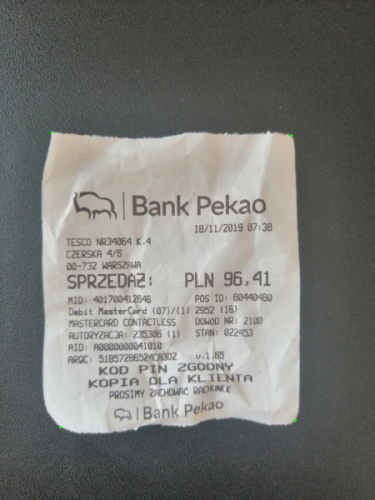

In [162]:
tmp = cv2.drawContours(img, contours=rectangle, contourIdx=-1, color=(0, 255, 0), thickness=2)
cv2_imshow(tmp)

Points extraction

In [163]:
points = rectangle.reshape(4, 2)
points = points * ratio
points

array([[349.2, 162. ],
       [ 61.2, 158.4],
       [ 72. , 512.4],
       [354. , 504. ]])

In [164]:
rectangle = np.zeros((4, 2), dtype='float32')
rectangle

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [165]:
total = points.sum(axis=1)
rectangle[0] = points[np.argmin(total)]
rectangle[2] = points[np.argmax(total)]
rectangle

array([[ 61.2, 158.4],
       [  0. ,   0. ],
       [354. , 504. ],
       [  0. ,   0. ]], dtype=float32)

In [166]:
difference = np.diff(points, axis=1)
rectangle[1] = points[np.argmin(difference)]
rectangle[3] = points[np.argmax(difference)]
rectangle

array([[ 61.2, 158.4],
       [349.2, 162. ],
       [354. , 504. ],
       [ 72. , 512.4]], dtype=float32)

In [167]:
a, b, c, d = rectangle

width_ab = norm(a - b)
width_cd = norm(c - d)
max_width = max(int(width_ab), int(width_cd))

height_ad = norm(a - d)
height_bc = norm(b - c)
max_height = max(int(height_ad), int(height_bc))

print(f'max width: {max_width}')
print(f'max height: {max_height}')

max width: 288
max height: 354


In [168]:
vertices= np.array([
                   [0, 0],
                   [max_width - 1, 0],
                   [max_width - 1, max_height - 1],
                   [0, max_height - 1]
], dtype='float32')

vertices

array([[  0.,   0.],
       [287.,   0.],
       [287., 353.],
       [  0., 353.]], dtype=float32)

Transform document into image

In [169]:
#matrix of trasformation
M = cv2.getPerspectiveTransform(rectangle, vertices)
M

array([[ 9.47714238e-01, -2.89133112e-02, -5.34202438e+01],
       [-1.20274799e-02,  9.62196799e-01, -1.51675885e+02],
       [-1.16837073e-04, -5.27577240e-05,  1.00000000e+00]])

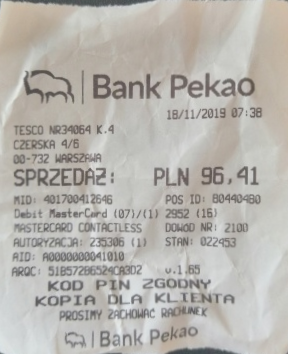

In [170]:
#document into image
out = cv2.warpPerspective(src=og_img, M=M, dsize=(max_width, max_height))
cv2_imshow(out)

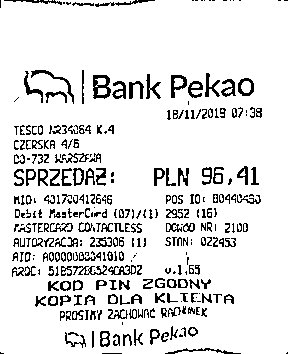

In [171]:
# gray scale
out = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)

# threshold base on pixel nieghbourhood
T = threshold_local(image=out, block_size=11, offset=10, method='gaussian')
out = (out > T).astype('uint8') * 255
cv2_imshow(out)